In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

2024-07-01 12:56:36.453884: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-01 12:56:36.455299: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-01 12:56:36.460063: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-01 12:56:36.472520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 12:56:36.488891: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

# Base

In [3]:
df_ratings = pd.read_csv('corporateCreditRatingWithFinancialRatios.csv')

In [4]:
input_columns = ['Current Ratio', 'Long-term Debt / Capital', 'Debt/Equity Ratio',
                 'Gross Margin', 'Operating Margin', 'EBIT Margin', 'EBITDA Margin',
                 'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover',
                 'ROE - Return On Equity', 'Return On Tangible Equity',
                 'ROA - Return On Assets', 'ROI - Return On Investment',
                 'Operating Cash Flow Per Share', 'Free Cash Flow Per Share']

# *Encoding*

A partir daqui, há uma diferenciação entre dois modelos testados, um com um neurônio na camada de saída (*label encoding*) e um com um neurônio por *rating* (*one hot encoding*).

In [5]:
label_encoder_dict = {
    "AAA": (round(0/25, 2), round(25/25, 2)),
    "AA+": (round(1/25, 2), round(24/25, 2)),
    "AA": (round(2/25, 2), round(23/25, 2)),
    "AA-": (round(3/25, 2), round(22/25, 2)),
    "A+": (round(4/25, 2), round(21/25, 2)),
    "A": (round(5/25, 2), round(20/25, 2)),
    "A-": (round(6/25, 2), round(19/25, 2)),
    "BBB+": (round(7/25, 2), round(18/25, 2)),
    "BBB": (round(8/25, 2), round(17/25, 2)),
    "BBB-": (round(9/25, 2), round(16/25, 2)),
    "BB+": (round(10/25, 2), round(15/25, 2)),
    "BB": (round(11/25, 2), round(14/25, 2)),
    "BB-": (round(12/25, 2), round(13/25, 2)),
    "B+": (round(13/25, 2), round(12/25, 2)),
    "B": (round(14/25, 2), round(11/25, 2)),
    "B-": (round(15/25, 2), round(10/25, 2)),
    "CCC+": (round(16/25, 2), round(9/25, 2)),
    "CCC": (round(17/25, 2), round(8/25, 2)),
    "CCC-": (round(18/25, 2), round(7/25, 2)),
    "CC+": (round(19/25, 2), round(6/25, 2)),
    "CC": (round(20/25, 2), round(5/25, 2)),
    "CC-": (round(21/25, 2), round(4/25, 2)),
    "C+": (round(22/25, 2), round(3/25, 2)),
    "C": (round(23/25, 2), round(2/25, 2)),
    "C-": (round(24/25, 2), round(1/25, 2)),
    "D": (round(25/25, 2), round(0/25, 2))
}

encoder_descending = 0

label_decoder_dict = {}
for k in label_encoder_dict.keys():
    label_decoder_dict[label_encoder_dict[k][encoder_descending]] = k

In [6]:
df_ratings["Rating Encoded"] = df_ratings["Rating"].apply(lambda x: label_encoder_dict[x.strip()][encoder_descending])

In [7]:
encoder = OneHotEncoder(sparse=False)

# Remoção de *outlayers* baseado em estudo prévio

In [8]:
ranges = {
    "Current Ratio": (-5, 20),
    "Long-term Debt / Capital": (-25, 15),
    "Debt/Equity Ratio": (-200, 250),
    "Gross Margin": (-25, 150),
    "Operating Margin": (-250, 100),
    "EBIT Margin": (-200, 100),
    "EBITDA Margin": (-200, 100),
    "Pre-Tax Profit Margin": (-100, 150),
    "Net Profit Margin": (-150, 150),
    "Asset Turnover": (-10, 6),
    "ROE - Return On Equity": (-2500, 2500),
    "Return On Tangible Equity": (-2500, 2500),
    "ROA - Return On Assets": (-100, 80),
    "ROI - Return On Investment": (-250, 250),
    "Operating Cash Flow Per Share": (-80, 100),
    "Free Cash Flow Per Share": (-50, 50)
}

for column in input_columns:
    df_ratings.drop(df_ratings[(df_ratings[column] < ranges[column][0]) | (df_ratings[column] > ranges[column][1])].index, inplace=True)

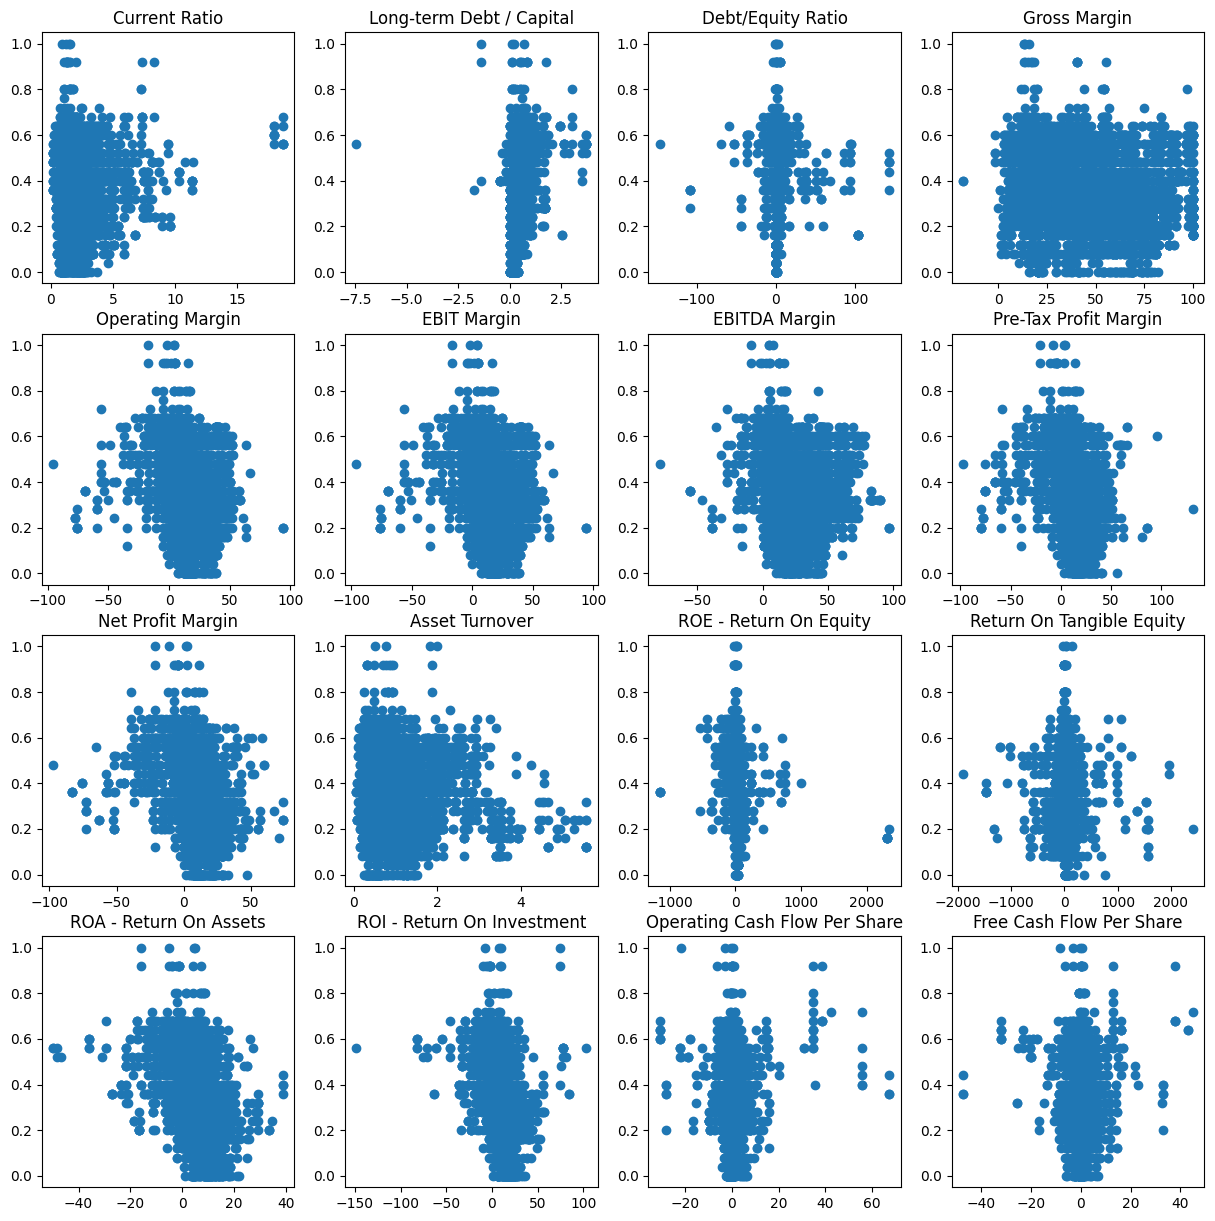

In [9]:
def subplot(ax, col):
    ax.scatter(df_ratings[[col]], df_ratings[['Rating Encoded']])
    ax.set_title(col)

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

k = 0

for i in range(4):
    for j in range(4):

        ax = plt.subplot2grid((4, 4), (i, j))

        col = input_columns[k]
        subplot(ax, col)
        k += 1

plt.show()

# Normalização

In [10]:
df_ratings[input_columns].describe()

,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
count,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000
mean,1.859531,0.447723,1.331032,42.518303,13.432001,13.474235,21.656053,10.581008,7.631680,0.849219,14.909975,11.452294,5.091764,8.151477,0.496853,0.155611
std,1.444251,0.311139,8.577603,23.452279,12.910765,12.937037,15.576307,13.640461,11.448321,0.679423,90.463266,149.608754,5.921622,10.395988,3.832381,3.467963
min,0.205400,-7.443000,-146.450000,-18.203900,-95.629500,-95.629500,-78.951000,-97.331300,-97.057100,0.068400,-1149.999000,-1900.000000,-49.752600,-148.372600,-30.758700,-47.240300
25%,1.077300,0.285500,0.425900,22.631200,6.389200,6.452100,11.256800,4.195100,2.887200,0.403200,6.228400,-11.052300,2.474100,3.933600,-0.419300,-0.707600
50%,1.497100,0.424800,0.755900,39.637400,12.343000,12.373200,18.501600,9.795200,7.043300,0.666700,12.530900,10.802700,4.855300,7.522400,0.239700,0.133500
75%,2.153700,0.534500,1.211300,59.568500,19.570500,19.619000,31.037200,16.873700,12.440800,1.039900,20.391900,26.894100,7.928400,12.556800,1.079700,0.978200
max,18.665100,3.712900,143.061600,100.000000,93.993000,93.993000,97.186600,131.386900,73.607800,5.553000,2345.020000,2410.121000,38.823000,103.315200,67.406100,44.922600


In [11]:
df_train = df_ratings[input_columns].copy().reset_index(drop=True)
# df_train.iloc[:, 0:-1] = StandardScaler().fit_transform(df_train.iloc[:, 0:-1].to_numpy())
df_train.iloc[:, 0:-1] = MinMaxScaler().fit_transform(df_train.iloc[:, 0:-1].to_numpy())

In [12]:
df_train.describe()

,Current Ratio,Long-term Debt / Capital,Debt/Equity Ratio,Gross Margin,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,Asset Turnover,ROE - Return On Equity,Return On Tangible Equity,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share,Free Cash Flow Per Share
count,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000,7621.000000
mean,0.089608,0.707314,0.510449,0.513707,0.575151,0.575373,0.571184,0.471813,0.613417,0.142366,0.333305,0.443480,0.619181,0.621898,0.318399,0.155611
std,0.078238,0.027890,0.029628,0.198405,0.068087,0.068225,0.088433,0.059639,0.067081,0.123878,0.025883,0.034711,0.066854,0.041305,0.039040,3.467963
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-47.240300
25%,0.047233,0.692772,0.507323,0.345463,0.538009,0.538341,0.512144,0.443893,0.585617,0.061044,0.330821,0.438259,0.589629,0.605139,0.309066,-0.707600
50%,0.069974,0.705259,0.508463,0.489335,0.569408,0.569567,0.553275,0.468378,0.609970,0.109087,0.332625,0.443329,0.616512,0.619398,0.315779,0.133500
75%,0.105543,0.715092,0.510036,0.657951,0.607523,0.607779,0.624445,0.499326,0.641596,0.177132,0.334874,0.447063,0.651206,0.639401,0.324336,0.978200
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,44.922600


# Amostras de treino e de teste

In [13]:
X = df_train[input_columns]

y = df_ratings['Rating Encoded']
y_one_hot = encoder.fit_transform(df_ratings[['Rating']])

/home/cmore/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_one_hot, X_test_one_hot, y_train_one_hot, y_test_one_hot = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Treinamento

In [15]:
# Uma saída

model_1 = Sequential([
    Dense(64, activation='relu', input_dim=len(X_train.columns)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_1.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

model_1.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

/home/cmore/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0113 - loss: 0.6496 - val_accuracy: 0.0125 - val_loss: 0.6305
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0118 - loss: 0.6332 - val_accuracy: 0.0125 - val_loss: 0.6293
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0111 - loss: 0.6302 - val_accuracy: 0.0125 - val_loss: 0.6291
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0134 - loss: 0.6315 - val_accuracy: 0.0125 - val_loss: 0.6289
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0138 - loss: 0.6322 - val_accuracy: 0.0125 - val_loss: 0.6288
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0101 - loss: 0.6316 - val_accuracy: 0.0125 - val_loss: 0.6286
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0140 - loss: 0.6326 - val_accuracy: 0.0125 - val_loss: 0.6284
Epoch 8/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0111 - loss: 0.6313 - val_accu

In [16]:
# Uma saída por rating

model_many = Sequential([
    Dense(64, activation='relu', input_dim=len(X_train_one_hot.columns)),
    Dense(64, activation='relu'),
    Dense(y_one_hot.shape[1], activation='softmax')
])

model_many.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_many.fit(X_train_one_hot, y_train_one_hot, epochs=100, batch_size=32, validation_data=(X_test_one_hot, y_test_one_hot))

Epoch 1/100


/home/cmore/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0964 - loss: 2.9446 - val_accuracy: 0.1154 - val_loss: 2.6798
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1132 - loss: 2.6944 - val_accuracy: 0.1161 - val_loss: 2.6477
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1171 - loss: 2.6937 - val_accuracy: 0.1207 - val_loss: 2.6488
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1246 - loss: 2.6598 - val_accuracy: 0.1161 - val_loss: 2.6401
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1262 - loss: 2.6520 - val_accuracy: 0.1252 - val_loss: 2.6308
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1341 - loss: 2.6558 - val_accuracy: 0.1298 - val_loss: 2.6201
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1333 - loss: 2.6363 - val_accuracy: 0.1351 - val_loss: 2.6026
Epoch 8/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1345 - loss: 2.6217 - val_accuracy: 0.1174

# Transformando saídas na classificação desejada

In [17]:
def result(x):
    for i in label_decoder_dict.keys():
        if abs(x - i) <= 0.02:
            return i
    return None

In [18]:
y_pred_1 = model_1.predict(X_test)
y_pred_1 = [result(yp) for yp in y_pred_1]

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [19]:
y_pred_many = model_many.predict(X_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [20]:
y_pred_many.argmax(axis=1).reshape(-1, 1)

array([[11],
       [ 0],
       [15],
       ...,
       [ 1],
       [ 8],
       [14]])

In [21]:
y_pred_many = y_pred_many.argmax(axis=1).reshape(-1, 1)
y_pred_many_rating = np.zeros((y_pred_many.size, y_one_hot.shape[1]))
y_pred_many_rating[np.arange(y_pred_many.size).reshape(-1, 1), y_pred_many] = 1
y_pred_many_rating

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
y_pred_many_rating = encoder.inverse_transform(y_pred_many_rating)
y_pred_many_rating

array([['BB+'],
       ['A'],
       ['BBB-'],
       ...,
       ['A+'],
       ['B+'],
       ['BBB+']], dtype=object)

# Análise dos resultados

- Resultado igual ao esperado:
    |Teste     |  Esperado |
    |----------|-----------|
    | AA $^+$  | AA $^+$   |

- Resultado igual ao esperado, desonsiderando *high* e *low*:
    |Teste     |  Esperado |
    |----------|-----------|
    | AA $^+$  | AA $^-$   |

- Mesma letra:
    |Teste     |  Esperado |
    |----------|-----------|
    | AA $^+$  | AAA       |

In [23]:
df_pred = pd.DataFrame({"Pred 1": y_pred_1, "Test": y_test}).reset_index(drop=True)

In [24]:
df_pred['Pred 1 Rating'] = df_pred['Pred 1'].apply(lambda x: label_decoder_dict[x])
df_pred['Pred Many Rating'] = y_pred_many_rating.reshape(1, -1).tolist()[0]
df_pred['Test Rating'] = df_pred['Test'].apply(lambda x: label_decoder_dict[x])

In [25]:
df_pred["1: Igual sem high/low"] = (df_pred['Pred 1 Rating'].str.replace("+", "").str.replace("-", "") ==
                                 df_pred['Test Rating'].str.replace("+", "").str.replace("-", ""))

df_pred["1: Mesma letra"] = df_pred['Pred 1 Rating'].str[0] == df_pred['Test Rating'].str[0]

df_pred["Many: Igual sem high/low"] = (df_pred['Pred Many Rating'].str.replace("+", "").str.replace("-", "") ==
                                       df_pred['Test Rating'].str.replace("+", "").str.replace("-", ""))

df_pred["Many: Mesma letra"] = df_pred['Pred Many Rating'].str[0] == df_pred['Test Rating'].str[0]

In [26]:
print("1 neurônio na camada de saída:")
print(f'Igual: {len(df_pred[df_pred["Pred 1 Rating"] == df_pred["Test Rating"]])/len(df_pred)}')
print(f'Igual sem high/low: {len(df_pred[df_pred["1: Igual sem high/low"]])/len(df_pred)}')
print(f'Mesma letra: {len(df_pred[df_pred["1: Mesma letra"]])/len(df_pred)}')

print("Um neurônio por rating na camada de saída:")
print(f'Igual: {len(df_pred[df_pred["Pred Many Rating"] == df_pred["Test Rating"]])/len(df_pred)}')
print(f'Igual sem high/low: {len(df_pred[df_pred["Many: Igual sem high/low"]])/len(df_pred)}')
print(f'Mesma letra: {len(df_pred[df_pred["Many: Mesma letra"]])/len(df_pred)}')

1 neurônio na camada de saída:
Igual: 0.12918032786885245
Igual sem high/low: 0.36131147540983605
Mesma letra: 0.6563934426229509
Um neurônio por rating na camada de saída:
Igual: 0.2137704918032787
Igual sem high/low: 0.4577049180327869
Mesma letra: 0.699672131147541
